In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



### Importação das bases

In [3]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

Entendendo os dados

In [3]:
sample.isna().sum()
test.isna().sum()
train.isna().sum()
## Não possui valores nulos

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

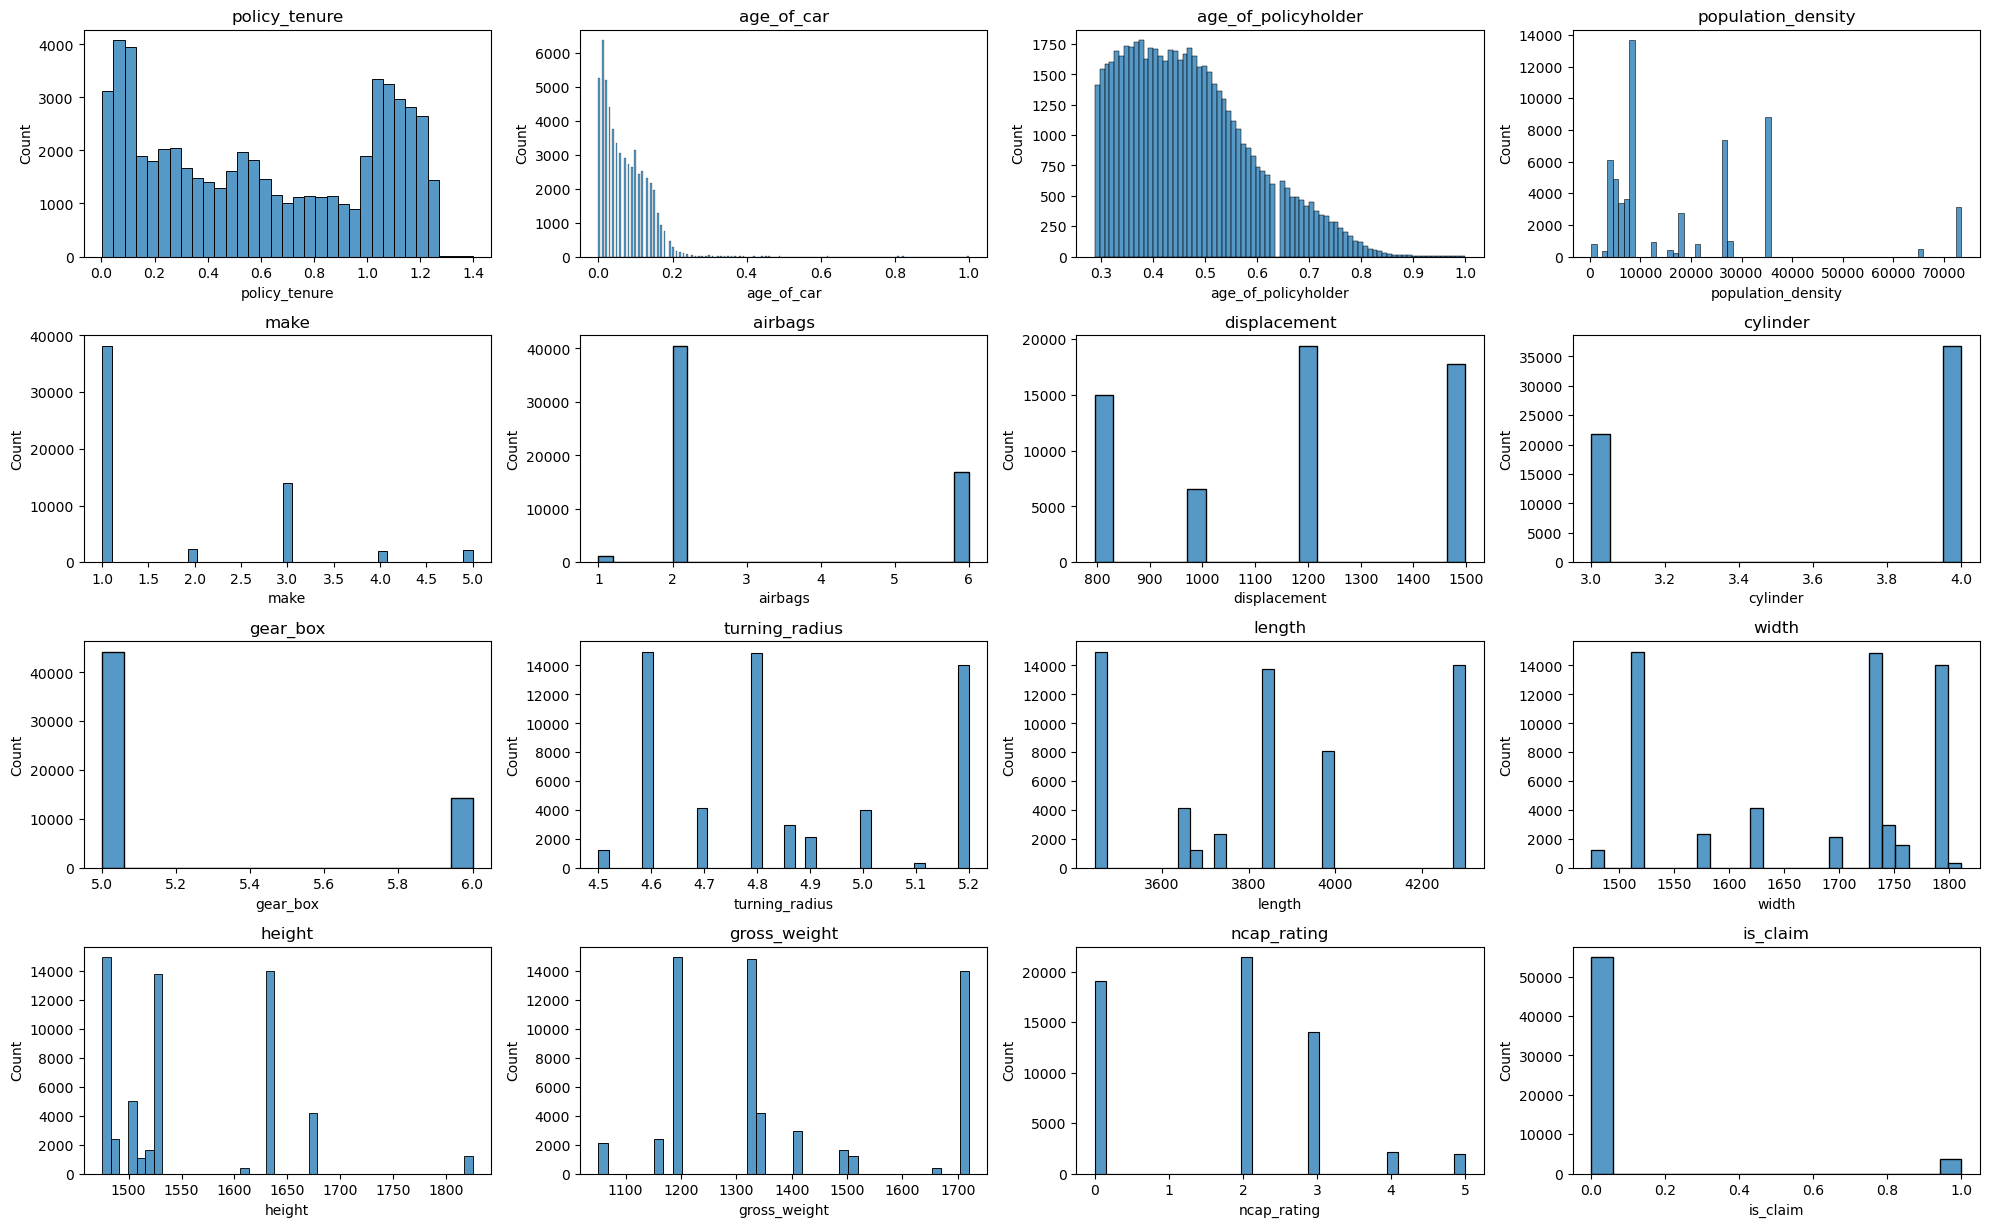

In [4]:
numeric_columns_train = train.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 15))

for i, column in enumerate(numeric_columns_train.columns):
    plt.subplot(5, 4, i + 1)
    sns.histplot(train[column], kde=False)
    plt.title(column)
    plt.tight_layout()

plt.show()


In [5]:
less_t_2m = train['age_of_car'] <= 0.2
porcentagem_less_t_2m = less_t_2m.sum()/train['age_of_car'].count()
round(porcentagem_less_t_2m,2)

0.99

In [6]:
two_airbag = train['airbags'] == 2
porcent_two_airbag = two_airbag.sum()/train['airbags'].count()
round(porcent_two_airbag,2)

0.69

In [7]:
ncap_5_or_4 = (train['ncap_rating'] == 5) | (train['ncap_rating'] == 4)
porcent_ncap_5_or_4 = ncap_5_or_4.sum()/train['ncap_rating'].count()
round(porcent_ncap_5_or_4,2)

0.07

#### Informações do histograma (Conclusão parcial:): 

Policy Tenure: A maior parte dos seguros ficou vigente por apenas 1 mês

Age of Car: A maior parte das pessoas optaram por fazer o seguro assim que compraram o carro (99%). 

AirBags: A maioria dos carros possuem 2 aribags (69%).

ncap: Apenas 7% dos carros possuem o rating de segurança ncap sendo 4 ou 5.

#### A ideia do próximo gráfico foi tirada do Zubin Relia (Kaggle), alterei as colunas de interesse.

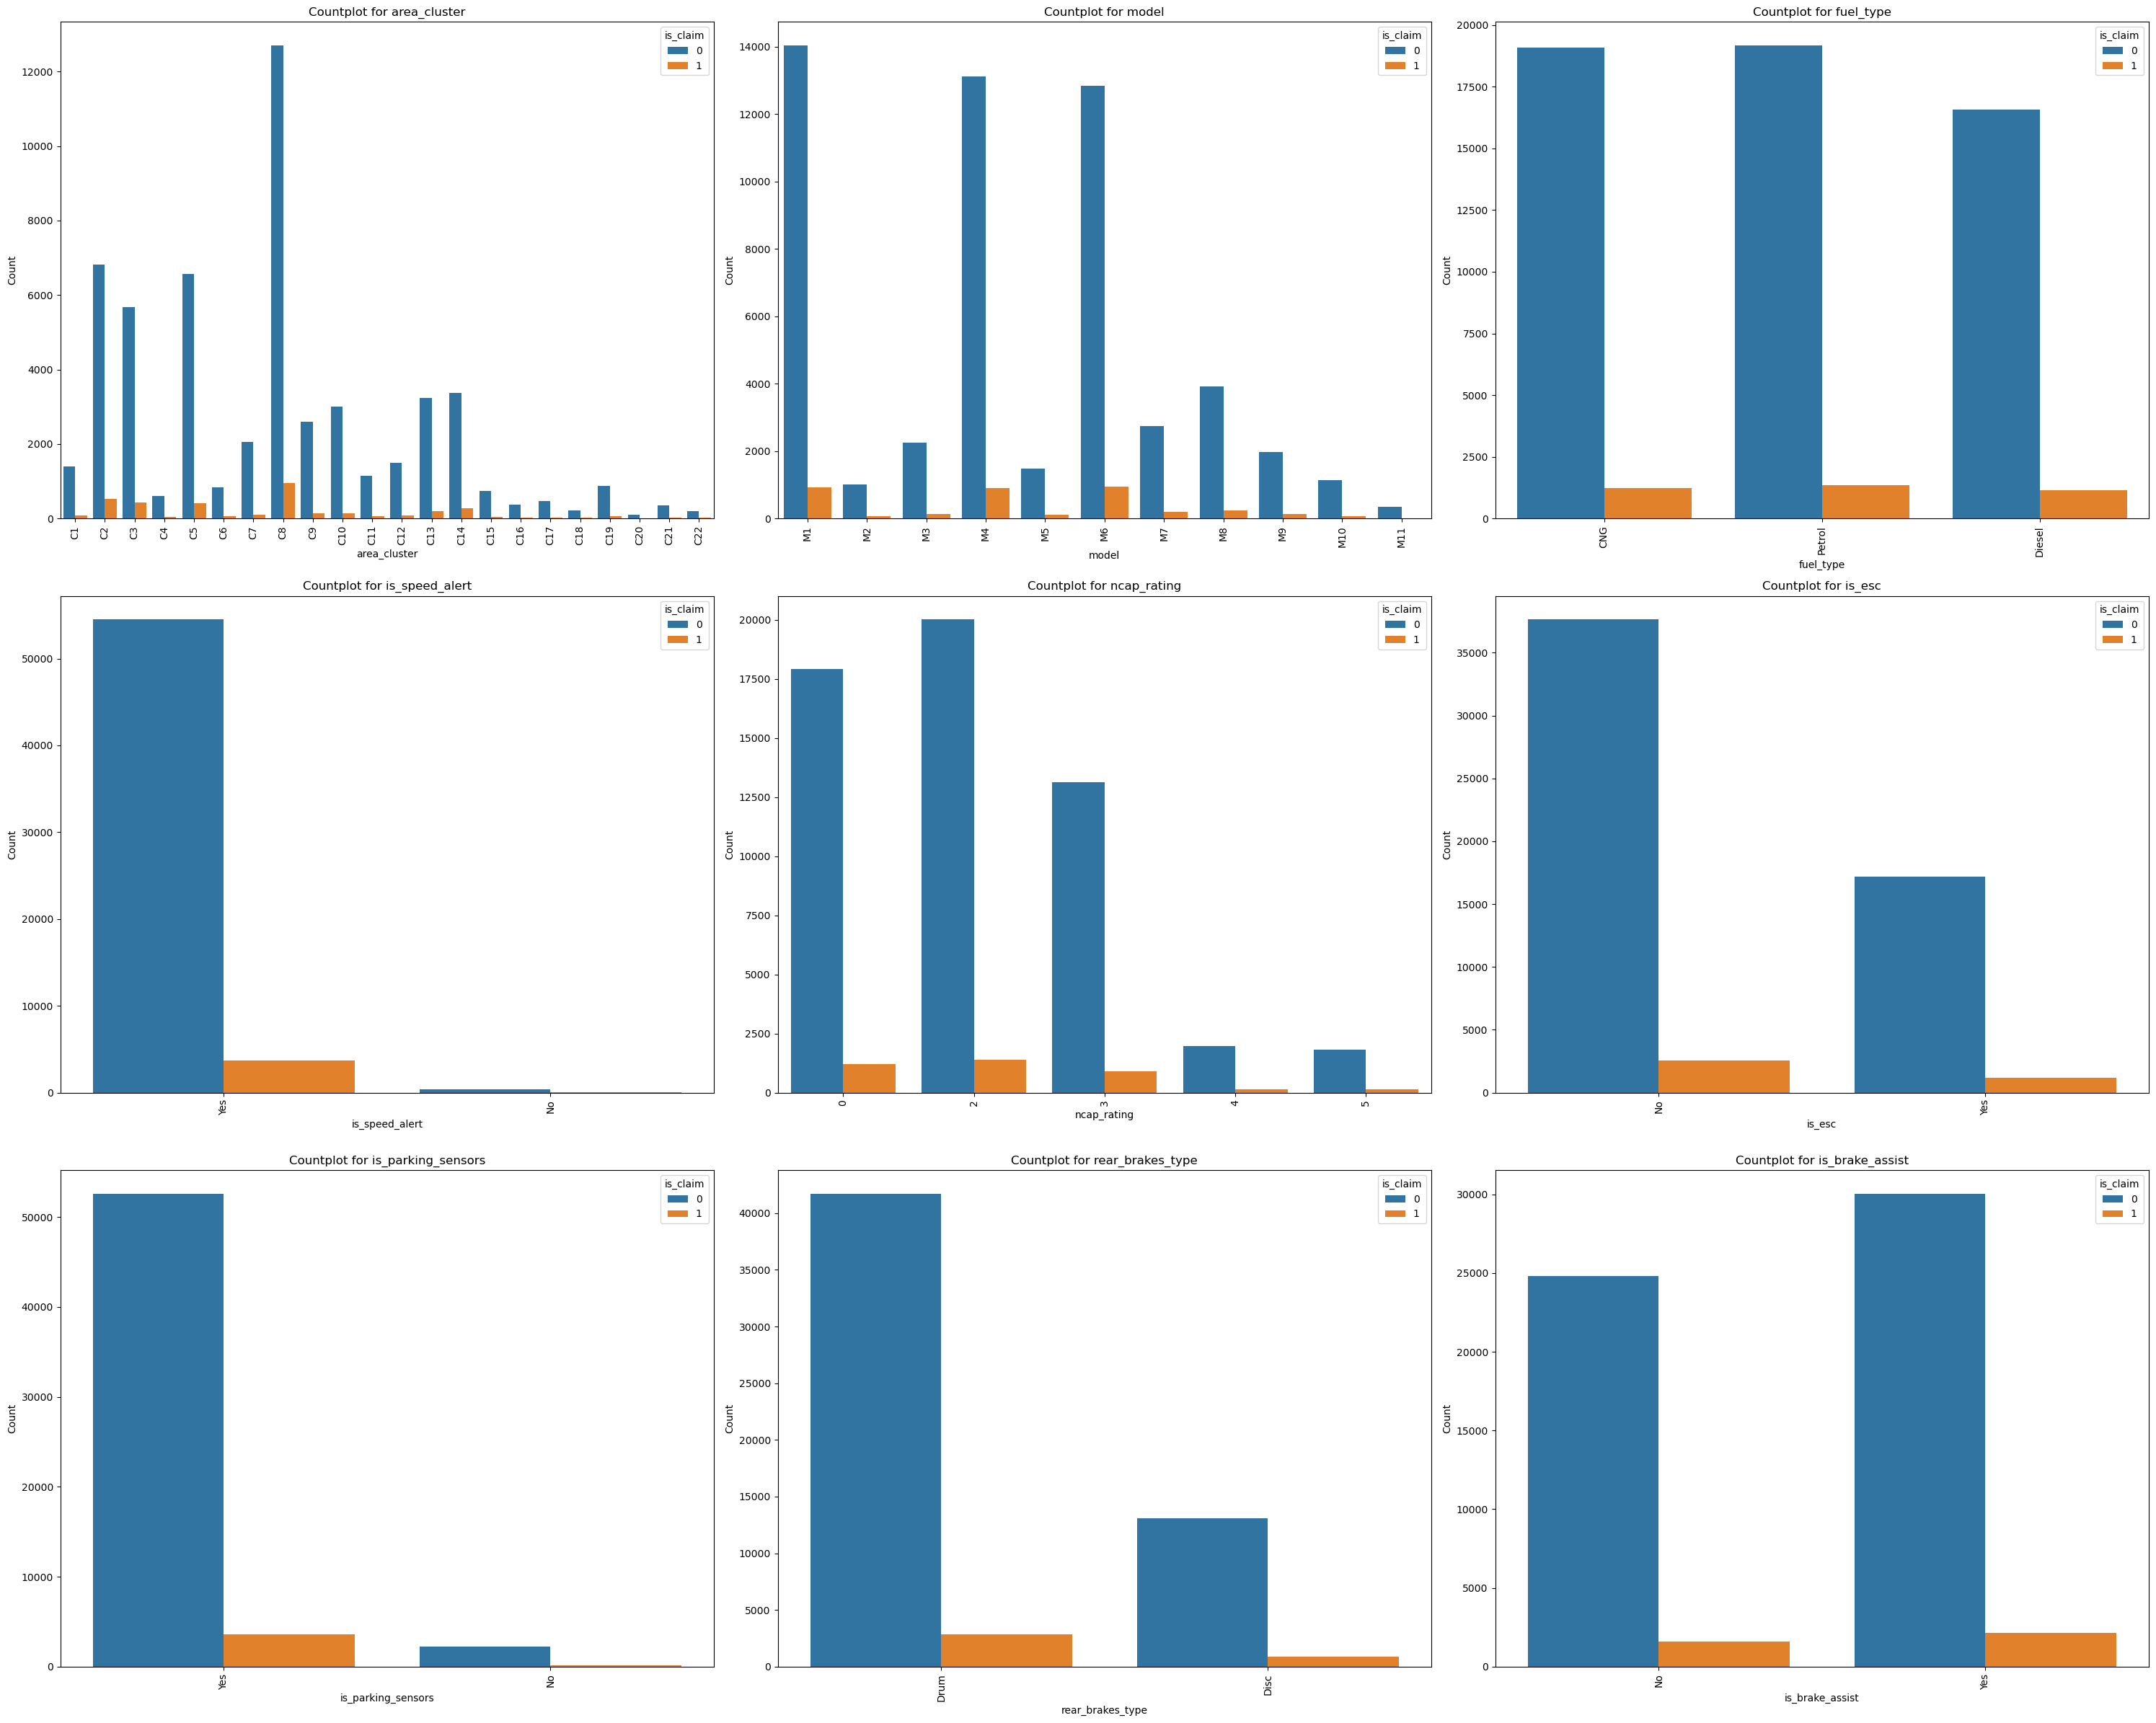

In [54]:
### Chart by Zubin Relia (From Kaggle)

fig, axes = plt.subplots(3,3, figsize=(30,24))
axes = axes.flatten()

cols_1=['area_cluster', 'model', 'fuel_type', 'is_speed_alert', 'ncap_rating', 'is_esc', 'is_parking_sensors', 'rear_brakes_type', 'is_brake_assist']

for i, column in enumerate(cols_1):
    ax = axes[i]  

  
    sns.countplot(data=train, x=column, ax=ax, hue='is_claim')
    ax.set_title(f'Countplot for {column}')
    
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)  
    
    

plt.tight_layout()


plt.show()

In [8]:
total_claim = train[train["is_claim"] == 1]

In [9]:
ncap_5_or_4_and_claim = ((train['ncap_rating'] == 5) | (train['ncap_rating'] == 4)) & (train['is_claim'] == 1)
porcentagem_ncap_5_or_4_and_claim = ncap_5_or_4_and_claim.sum()/total_claim["ncap_rating"].count().sum()
round(porcentagem_ncap_5_or_4_and_claim,2)

0.07

In [10]:
ncap_0_to_3_and_claim = ((train['ncap_rating'] == 0) | (train['ncap_rating'] == 1) | (train['ncap_rating'] == 2) | (train['ncap_rating'] == 3)) & (train['is_claim'] == 1)
total_claim = train[train["is_claim"] == 1]
porcent_ncap_0_to_3_and_claim = ncap_0_to_3_and_claim.sum()/total_claim["ncap_rating"].count().sum()
round(porcent_ncap_0_to_3_and_claim,2)

0.93

In [11]:
drum_brakes_and_claim = train[(train['rear_brakes_type'] == 'Drum') & (train['is_claim'] == 1)]
drum_brakes = len(drum_brakes_and_claim) / total_claim['rear_brakes_type'].count()
round(drum_brakes, 2)


0.76

In [12]:
drum_brakes_tot = len(train[train['rear_brakes_type'] == 'Drum']) / train['rear_brakes_type'].count()
round(drum_brakes_tot, 2)

0.76

#### Conclusão parcial:

Os carros com Ncap entre 0 e 3 representam 93% de todos os carros. E também representam 93% dos carros que utilizaram o seguro.

Existem dois tipos de freios, os freios Drum e os Disc, 76% dos seguros que foram utilizados estavam utilizando os freios Drum. Era esperado uma porcentagem maior pois os no total os freios Drum representam também 76% do total dos freios, o que é uma coincidência.

In [16]:
train_heatmap = pd.DataFrame()

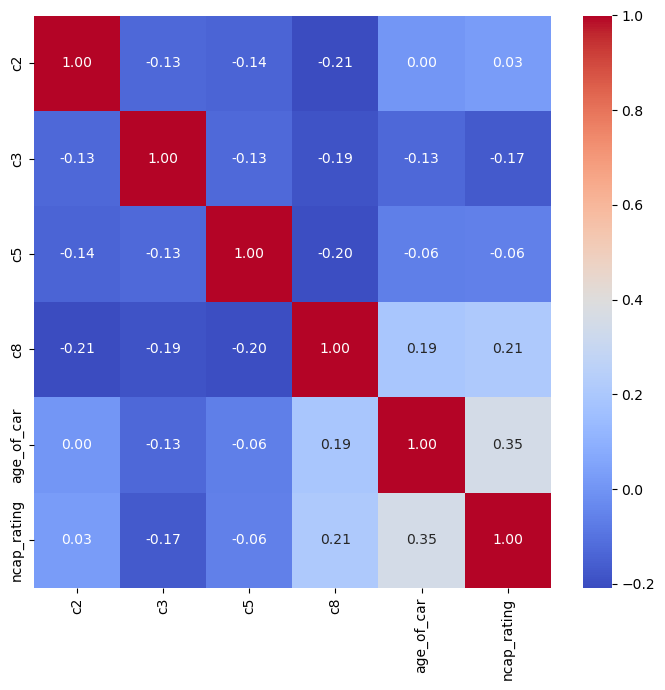

In [17]:
train_heatmap['c2'] = train['area_cluster'].apply(lambda x: 1 if x == 'C2' else 0)
train_heatmap['c3'] = train['area_cluster'].apply(lambda x: 1 if x == 'C3' else 0)
train_heatmap['c5'] = train['area_cluster'].apply(lambda x: 1 if x == 'C5' else 0)
train_heatmap['c8'] = train['area_cluster'].apply(lambda x: 1 if x == 'C8' else 0)
train_heatmap['age_of_car'] = train['age_of_car']
train_heatmap['ncap_rating'] = train['ncap_rating']

fig, axes = plt.subplots(figsize=(7, 7))
sns.heatmap(train_heatmap.corr(), annot=True, fmt=".2f", cmap="coolwarm", )
plt.tight_layout()
plt.show()



# ML: 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
train = pd.read_csv('train.csv') 
train_no_claims = pd.read_csv('train.csv')
train_no_claims = train_no_claims.drop('is_claim', axis=1)

#### Modelo clássico de Regressão Logistica:

In [45]:
features = train_no_claims.select_dtypes(include=['float64', 'int64'])
target = train['is_claim']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state= 42)
model = LogisticRegression(class_weight='balanced')
#class_weight='balanced'
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[5436 8238]
 [ 371  603]]
              precision    recall  f1-score   support

           0       0.94      0.40      0.56     13674
           1       0.07      0.62      0.12       974

    accuracy                           0.41     14648
   macro avg       0.50      0.51      0.34     14648
weighted avg       0.88      0.41      0.53     14648



In [46]:
test_features = test.select_dtypes(include=['float64', 'int64'])
test_predictions = model.predict(test_features)
test['is_claim'] = test_predictions
test.to_csv('testans.csv', index=False)


#### Hiperparâmetros

Primeira tentativa com os Hiperparâmetros:

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state= 42)

# Normalização das características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criação do modelo com RFE para seleção de características
model = LogisticRegression(class_weight='balanced')
rfe = RFE(model, n_features_to_select=10)  # Ajuste para o número desejado de características
rfe.fit(X_train_scaled, y_train)

# Previsões com características selecionadas
predictions = rfe.predict(X_test_scaled)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Otimização de Hiperparâmetros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(model, param_grid, cv=15)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)

# Avaliar o modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[9269 7148]
 [ 515  646]]
              precision    recall  f1-score   support

           0       0.95      0.56      0.71     16417
           1       0.08      0.56      0.14      1161

    accuracy                           0.56     17578
   macro avg       0.52      0.56      0.43     17578
weighted avg       0.89      0.56      0.67     17578

{'C': 0.01, 'penalty': 'l2'}
[[9319 7098]
 [ 506  655]]
              precision    recall  f1-score   support

           0       0.95      0.57      0.71     16417
           1       0.08      0.56      0.15      1161

    accuracy                           0.57     17578
   macro avg       0.52      0.57      0.43     17578
weighted avg       0.89      0.57      0.67     17578



Segunda Tentativa com Hiperparâmetros:

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state= 42)

# Normalização das características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criação do modelo com RFE para seleção de características
model = LogisticRegression(class_weight='balanced')
rfe = RFE(model, n_features_to_select=10)  # Ajuste para o número desejado de características
rfe.fit(X_train_scaled, y_train)

# Previsões com características selecionadas
predictions = rfe.predict(X_test_scaled)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Otimização de Hiperparâmetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [300, 500, 800],
    'tol': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)

# Avaliar o modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[9269 7148]
 [ 515  646]]
              precision    recall  f1-score   support

           0       0.95      0.56      0.71     16417
           1       0.08      0.56      0.14      1161

    accuracy                           0.56     17578
   macro avg       0.52      0.56      0.43     17578
weighted avg       0.89      0.56      0.67     17578

Fitting 5 folds for each of 630 candidates, totalling 3150 fits


/home/ikaro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ikaro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ikaro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ikaro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ikaro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ikaro/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

{'C': 0.001, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.01}
[[9196 7221]
 [ 508  653]]
              precision    recall  f1-score   support

           0       0.95      0.56      0.70     16417
           1       0.08      0.56      0.14      1161

    accuracy                           0.56     17578
   macro avg       0.52      0.56      0.42     17578
weighted avg       0.89      0.56      0.67     17578



# Conclusão

#### Objetivo do Projeto
O projeto focou na construção de um modelo preditivo de machine learning para prever a probabilidade de reivindicações de seguro de veículos (is_claim) com base em um conjunto de características do veículo e do titular da apólice.

#### Abordagem e Análise

Preparação e Exploração dos Dados:

Carreguei e explorei os conjuntos de dados train.csv e test.csv.
Realizei a descrição e verificação de valores nulos nos conjuntos de dados.
Executei a análise exploratória de dados, incluindo a visualização de distribuições de características importantes.
Pré-Processamento dos Dados:

Fiz a codificação de variáveis categóricas e a normalização de características numéricas.
Lidei com questões de desbalanceamento de classes, essenciais para um modelo de classificação eficaz.


#### Construção do Modelo:

Escolhi a regressão logística como nosso modelo inicial, considerando sua simplicidade e eficácia em problemas de classificação binária.
Implementamos a regularização e a seleção de características para otimizar o desempenho do modelo.

#### Otimização de Hiperparâmetros:

Realizei uma busca em grade para encontrar a melhor combinação de hiperparâmetros, incluindo C, penalty, solver, max_iter, e tol.


#### Avaliação do Modelo:

Usei métricas como precisão, recall, F1-score e a matriz de confusão para avaliar o modelo.
Identificamos o desafio de prever corretamente a classe minoritária (is_claim = 1) e implementei estratégias para melhorar o recall desta classe.


#### Aplicação do Modelo no Conjunto de Teste:

Preparei o conjunto de teste com as mesmas transformações do conjunto de treino.
Apliquei o modelo treinado para fazer previsões no conjunto de teste e criei um arquivo CSV com os resultados.